## now we having reduced the features to 6 from 30
## by neglecting the features whose correlation is <abs(0.1) with the prediction from 10% k-means
## Once we have all features whose correlation is >abs(0.1), then again we checked intercorrelation of these features
## and we clubbed features to one which were having intercorrelation >abs(0.8)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import scipy
from PIL import Image
from scipy import ndimage
import gdal
import os
import geopandas as gpd
from skimage import io
from skimage.io import imread
%matplotlib inline

In [2]:
np.random.seed(1)

In [3]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans

C:\Users\Lenovo\anaconda3\envs\env_1\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


# reading the masked tif images and forming a dataset.

In [13]:
path = ["E:\\Internship_Harvesting\\Dataset\\Bathinda_Cropland\\Masked_images\\I1B1.tif",
       "E:\\Internship_Harvesting\\Dataset\\Bathinda_Cropland\\Masked_images\\I3B1.tif",
       "E:\\Internship_Harvesting\\Dataset\\Bathinda_Cropland\\Masked_images\\I4B4.tif",
       "E:\\Internship_Harvesting\\Dataset\\Bathinda_Cropland\\Masked_images\\I4B5.tif",
       "E:\\Internship_Harvesting\\Dataset\\Bathinda_Cropland\\Masked_images\\I5B1.tif",
       "E:\\Internship_Harvesting\\Dataset\\Bathinda_Cropland\\Masked_images\\I5B5.tif"]

In [5]:
I1B1 = gdal.Open(path[0])
I1B1

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x00000186D2EAA2D0> >

In [6]:
I1B1.RasterYSize, I1B1.RasterXSize, I1B1.RasterCount

(8963, 8298, 1)

In [7]:
I1B1_array = I1B1.GetRasterBand(1).ReadAsArray()
I1B1_array

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [8]:
np.count_nonzero(np.isnan(I1B1_array)), np.count_nonzero(~np.isnan(I1B1_array))

(40574909, 33800065)

# creating an array which only consists the non-nan values indices

In [9]:
# I1B1_nan_index = np.argwhere(np.isnan(I1B1))

I1B1_non_nan_index = np.argwhere(~np.isnan(I1B1_array))

In [10]:
I1B1_non_nan_index

array([[   0, 5738],
       [   0, 5739],
       [   0, 5740],
       ...,
       [8962, 5788],
       [8962, 5789],
       [8962, 5790]], dtype=int64)

In [11]:
I1B1_array[0, 5738], I1B1_array[0, 5739], I1B1_array[8962, 5789], I1B1_array[8962, 5790]

(1249.0, 1242.0, 1248.0, 1237.0)

In [14]:
I1B1_non_nan_index.shape

(33800065, 2)

# we have randomly sampled indices now we will make the sample dataset using this indices

In [15]:
test_x = np.zeros((1, 33800065))

In [16]:
for p in path:
    print(p)
    
    image = gdal.Open(p)
    
    image_array = image.GetRasterBand(1).ReadAsArray()
    print(image_array.shape)
    sample = []
    
    for i in range(I1B1_non_nan_index.shape[0]):
        sample.append(image_array[I1B1_non_nan_index[i,0], I1B1_non_nan_index[i,1]])
        
    sample = np.array(sample)
    
    sample = sample.reshape(1, 33800065)
        
    test_x = np.concatenate((sample, test_x), axis = 0)
    
    print(test_x.shape)
    
    print("***************")
    

E:\Internship_Harvesting\Dataset\Bathinda_Cropland\Masked_images\I1B1.tif
(8963, 8298)
(2, 33800065)
***************
E:\Internship_Harvesting\Dataset\Bathinda_Cropland\Masked_images\I3B1.tif
(8963, 8298)
(3, 33800065)
***************
E:\Internship_Harvesting\Dataset\Bathinda_Cropland\Masked_images\I4B4.tif
(8963, 8298)
(4, 33800065)
***************
E:\Internship_Harvesting\Dataset\Bathinda_Cropland\Masked_images\I4B5.tif
(8963, 8298)
(5, 33800065)
***************
E:\Internship_Harvesting\Dataset\Bathinda_Cropland\Masked_images\I5B1.tif
(8963, 8298)
(6, 33800065)
***************
E:\Internship_Harvesting\Dataset\Bathinda_Cropland\Masked_images\I5B5.tif
(8963, 8298)
(7, 33800065)
***************


In [18]:
test_x = test_x[:6, :]

In [24]:
test_x.shape

(6, 33800065)

# feature normalizing

In [25]:
for i in range(test_x.shape[0]):
    averg = np.mean(test_x[i, :])
    
    std_dev = np.std(test_x[i, :])
    
    test_x[i, :] = (test_x[i, :] - averg) / std_dev

In [44]:
test_x = test_x.T

In [45]:
test_x.shape

(33800065, 6)

# we have our test data, we will apply K-means unsupervised algorithm on this and capture details

# https://towardsdatascience.com/machine-learning-algorithms-part-9-k-means-example-in-python-f2ad05ed5203

# reference for the below mentioned code

In [46]:
wcss = []

In [51]:
for i in range(1, 4):
    
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=10, random_state=0)
    print("1", i)
    kmeans.fit(test_x)
    print("2", i)
    wcss.append(kmeans.inertia_)
    print("3", i)

1 1
2 1
3 1
1 2
2 2
3 2
1 3
2 3
3 3


In [52]:
wcss

[202800389.99999905,
 130633135.31588425,
 108003766.97196347,
 202800389.99999905,
 130632923.03674513,
 108003766.97196347]

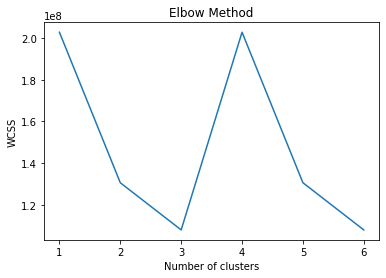

In [54]:
plt.plot(range(1, 7), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [55]:
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=50, n_init=5, random_state=0)
test_y = kmeans.fit_predict(test_x)

In [56]:
np.unique(test_y)

array([0, 1])

In [57]:
test_y.shape, test_x.shape

((33800065,), (33800065, 6))

In [58]:
test_y = test_y.reshape(33800065, 1)
test_y.shape

(33800065, 1)

In [60]:
I1B1_non_nan_index.shape

(33800065, 2)

In [62]:
result_index = np.concatenate((I1B1_non_nan_index, test_y), axis = 1)
result_index

array([[   0, 5738,    0],
       [   0, 5739,    0],
       [   0, 5740,    0],
       ...,
       [8962, 5788,    1],
       [8962, 5789,    1],
       [8962, 5790,    1]], dtype=int64)

In [63]:
result = np.zeros((8963, 8298))

In [64]:
result[:] = 128

In [66]:
result = result.astype("int")

In [67]:
for i in range(result_index.shape[0]):
    result[result_index[i,0], result_index[i,1]] = result_index[i, 2]

In [68]:
result

array([[128, 128, 128, ..., 128, 128, 128],
       [128, 128, 128, ..., 128, 128, 128],
       [128, 128, 128, ..., 128, 128, 128],
       ...,
       [128, 128, 128, ..., 128, 128, 128],
       [128, 128, 128, ..., 128, 128, 128],
       [128, 128, 128, ..., 128, 128, 128]])

In [69]:
np.unique(result)

array([  0,   1, 128])

In [70]:
result[result[:] == 0] = 255

In [71]:
np.unique(result)

array([  1, 128, 255])

In [72]:
result[result[:] == 1] = 0

In [73]:
np.unique(result)

array([  0, 128, 255])

In [74]:
# here 0 --> 1 during classification(minority)
# 255 --> 0 during classification(majority)
# 128 --> nan values (non-agri plus outside boundary)

In [75]:
result = result.astype("uint8")

In [77]:
result.shape

(8963, 8298)

In [78]:
io.imsave("E:\\Internship_Harvesting\\Unsupervised_Result_Image\\feature_red_kmeans_result.jpg", result)